---
title: 'Lab 8'
author: "Hunter Blinkenberg"
embed-resources: true
format: 
    html:
        toc: true
        code-fold: true
        theme: yeti
        echo: true
---

In [47]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
import warnings
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.exceptions import FitFailedWarning
from sklearn.svm import SVC
from sklearn.tree import plot_tree

In [101]:
url = "https://www.dropbox.com/s/s2a1uoiegitupjc/cannabis_full.csv?dl=1"
cbd = pd.read_csv(url)
cbd = cbd.dropna()

Ethics Statement and References: The goal of this lab will be to fit models that identify the Sativa types from the Indica types, and then to fit models that also distinguish the Hybrid types.

# Part One: Binary Classification

In [102]:
two = cbd[cbd['Type'].isin(["sativa", "indica"])]

In [103]:
X = two.drop(["Strain", "Type", "Effects", "Flavor"], axis= 1)

y= two["Type"]

For each, you should:

Choose a metric you will use to select your model, and briefly justify your choice. (Hint: There is no specific target category here, so this should not be a metric that only prioritizes one category.)

Find the best model for predicting the Type variable. Don’t forget to tune any hyperparameters.

Report the (cross-validated!) metric.

Fit the final model.

Output a confusion matrix.

In [86]:
two["Type"].value_counts()

Type
indica    659
sativa    409
Name: count, dtype: int64

Since there are no target categories, I will use the weighted F1 score for all models since the classes are slightly imbalanced and need a more robust statistic rather than accuracy. Weighting the f1 score will also be able to account for more classes than binary classification. 

In [104]:
# Define the preprocessing step
ct = ColumnTransformer(
    [
        ("dummify", 
         OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
         make_column_selector(dtype_include=object)),
        ("standardize", 
         StandardScaler(), 
         make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
).set_output(transform="pandas")

def evaluate_grid_search(grid_search, X, y):
    """
    This function performs grid search, evaluates the best model, and prints the results.

    Parameters:
    - grid_search: The GridSearchCV object that has been set up with the pipeline and parameter grid.
    - X: The feature matrix.
    - y: The target vector.

    Returns:
    - None
    """
    # Suppress warnings only in this block
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", FitFailedWarning)
        grid_search.fit(X, y)  # Perform GridSearchCV without warnings

    # Output the best parameters and ROC-AUC score
    print("Best Parameters:", grid_search.best_params_)
    print(f"Best Cross-validated Metric: {grid_search.best_score_:.4f}")

    # Make predictions with the best estimator
    y_pred = grid_search.best_estimator_.predict(X)

    # Print the classification report and confusion matrix
    print("Classification Report:")
    print(classification_report(y, y_pred))

    print("Confusion Matrix:")
    print(confusion_matrix(y, y_pred))

# Example usage:
# evaluate_grid_search(grid_search, X, y)

## Q1: LDA 

In [105]:
# unused solvers: "svd", "lsqr", 
param_grid = {
    "lda__solver": ["eigen"],  # Different solvers for LDA
    "lda__priors": [None],  # Uniform priors or None (learned from the data)
    "lda__n_components": [1, 2, 3],  # Different number of components (for dimensionality reduction)
    "lda__shrinkage": ["auto"],  # Only applicable if solver="lsqr"
    "lda__tol": [1e-4, 1e-3]  # Different tolerance levels
}

# Define the pipeline for LDA 
lda_pipeline = Pipeline(
    [("preprocessing", ct),
     ("lda", LinearDiscriminantAnalysis())]  # Default classifier
)

# Fit the GridSearchCV
grid_search = GridSearchCV(
    lda_pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=5),  # Ensures proper class distribution
    scoring="f1_weighted",
    n_jobs=-1
)

evaluate_grid_search(grid_search, X, y)


Best Parameters: {'lda__n_components': 1, 'lda__priors': None, 'lda__shrinkage': 'auto', 'lda__solver': 'eigen', 'lda__tol': 0.0001}
Best Cross-validated Metric: 0.8659
Classification Report:
              precision    recall  f1-score   support

      indica       0.90      0.91      0.90       659
      sativa       0.85      0.83      0.84       409

    accuracy                           0.88      1068
   macro avg       0.88      0.87      0.87      1068
weighted avg       0.88      0.88      0.88      1068

Confusion Matrix:
[[601  58]
 [ 69 340]]


c:\Users\hblin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [0.86589097 0.86589097        nan        nan        nan        nan]


## Q2: QDA

In [106]:
param_grid = {
    'qda__priors': [None, .5],  # Priors for class probabilities
    'qda__reg_param': [0.0, 0.1, 0.5],  # Regularization parameter (optional)
    'qda__tol': [1e-4, 1e-3]  # Tolerance for eigenvalue decomposition (optional)
}

# Define the pipeline for QDA 
qda_pipeline = Pipeline(
    [("preprocessing", ct),
     ("qda", QuadraticDiscriminantAnalysis())]  # Default classifier
)

# Fit the GridSearchCV
grid_search = GridSearchCV(
    qda_pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=5),  # Ensures proper class distribution
    scoring="f1_weighted",
    n_jobs=-1
)

evaluate_grid_search(grid_search, X, y)

Best Parameters: {'qda__priors': None, 'qda__reg_param': 0.5, 'qda__tol': 0.0001}
Best Cross-validated Metric: 0.7910
Classification Report:
              precision    recall  f1-score   support

      indica       0.91      0.86      0.88       659
      sativa       0.79      0.86      0.82       409

    accuracy                           0.86      1068
   macro avg       0.85      0.86      0.85      1068
weighted avg       0.86      0.86      0.86      1068

Confusion Matrix:
[[566  93]
 [ 58 351]]


c:\Users\hblin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [0.45716985 0.45716985 0.77782164 0.77782164 0.79101703 0.79101703
        nan        nan        nan        nan        nan        nan]
c:\Users\hblin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear


## Q3: SVC

In [107]:
param_grid = {
    "svc__C": [0.1, 1, 10, 100, 1000],
    "svc__class_weight": [None, 'balanced'],
    "svc__shrinking": [True, False],
    "svc__tol": [1e-4, 1e-5, 1e-6],
    "svc__max_iter": [1000, 5000, -1]
}

svc_pipeline = Pipeline([
    ("preprocessing", ct),
    ("svc", SVC(probability=True))  # Use probability=True for probability outputs
])

# Define the parameter grid for C (regularization parameter)

grid_search = GridSearchCV(
    svc_pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=5),  # Ensures proper class distribution
    scoring="f1_weighted",
    n_jobs=-1
)

evaluate_grid_search(grid_search, X, y)

Best Parameters: {'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__max_iter': 1000, 'svc__shrinking': True, 'svc__tol': 0.0001}
Best Cross-validated Metric: 0.8442
Classification Report:
              precision    recall  f1-score   support

      indica       0.96      0.94      0.95       659
      sativa       0.90      0.93      0.92       409

    accuracy                           0.94      1068
   macro avg       0.93      0.93      0.93      1068
weighted avg       0.94      0.94      0.94      1068

Confusion Matrix:
[[618  41]
 [ 28 381]]


## Q4: SVM 

In [108]:
# too computationally expensive params 
    # "svc__gamma": ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    # "svc__degree": [2, 3, 4],
    # "svc__coef0": [0, 0.5, 1],
param_grid = {
    "svc__C": [0.1, 1, 10, 100, 1000],
    "svc__kernel": ['poly'],
    "svc__class_weight": [None, 'balanced'],
    "svc__shrinking": [True, False],
    "svc__tol": [1e-4, 1e-5, 1e-6],
    "svc__max_iter": [1000, 5000, -1]
}

svc_pipeline = Pipeline([
    ("preprocessing", ct),
    ("svc", SVC(probability=True))  # Use probability=True for probability outputs
])

# Define the parameter grid for C (regularization parameter)

grid_search = GridSearchCV(
    svc_pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=5),  # Ensures proper class distribution
    scoring="f1_weighted",
    n_jobs=-1
)

evaluate_grid_search(grid_search, X, y)


Best Parameters: {'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__kernel': 'poly', 'svc__max_iter': 5000, 'svc__shrinking': True, 'svc__tol': 0.0001}
Best Cross-validated Metric: 0.8490
Classification Report:
              precision    recall  f1-score   support

      indica       0.98      0.99      0.99       659
      sativa       0.99      0.97      0.98       409

    accuracy                           0.98      1068
   macro avg       0.98      0.98      0.98      1068
weighted avg       0.98      0.98      0.98      1068

Confusion Matrix:
[[653   6]
 [ 13 396]]


# Part 2: Natural Multiclass

In [109]:
X = cbd.drop(["Strain", "Type", "Effects", "Flavor"], axis= 1)

y= cbd["Type"]

In [98]:
cbd["Type"].value_counts()

Type
hybrid    1123
indica     659
sativa     409
Name: count, dtype: int64

## Q1: Decision Tree 

In [112]:
param_grid = {
    "dt__max_depth": [3, 7, 10, None],  # Vary max depth of the tree
    "dt__min_samples_split": [2, 5, 10],  # Vary minimum samples to split
    "dt__min_samples_leaf": [1, 2, 4],    # Vary minimum samples per leaf
    "dt__criterion": ["gini", "entropy"]  # Vary the splitting criterion
}

# Define the pipeline with DecisionTreeClassifier
dt_pipeline = Pipeline(
    [("preprocessing", ct),
     ("dt", DecisionTreeClassifier())]
)

# Set up GridSearchCV for cross-validation and hyperparameter search
grid_search = GridSearchCV(dt_pipeline, param_grid, cv=StratifiedKFold(n_splits=5), scoring='f1_weighted', n_jobs=-1)

# Fit the GridSearchCV with your data
grid_search.fit(X, y)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('dummify',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002A866EC4320>),
                                                                        ('standardize',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002A8624312E0>)])),
                                       ('dt', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'dt__criterion': ['gini', 'entropy'],
                         'dt__max_depth': [3, 7, 10, None],
                         'dt__min_samples_leaf': [1, 2, 4],
                         'dt__min_samples_split': [2, 5, 10]},
             scoring='f1_weighted')

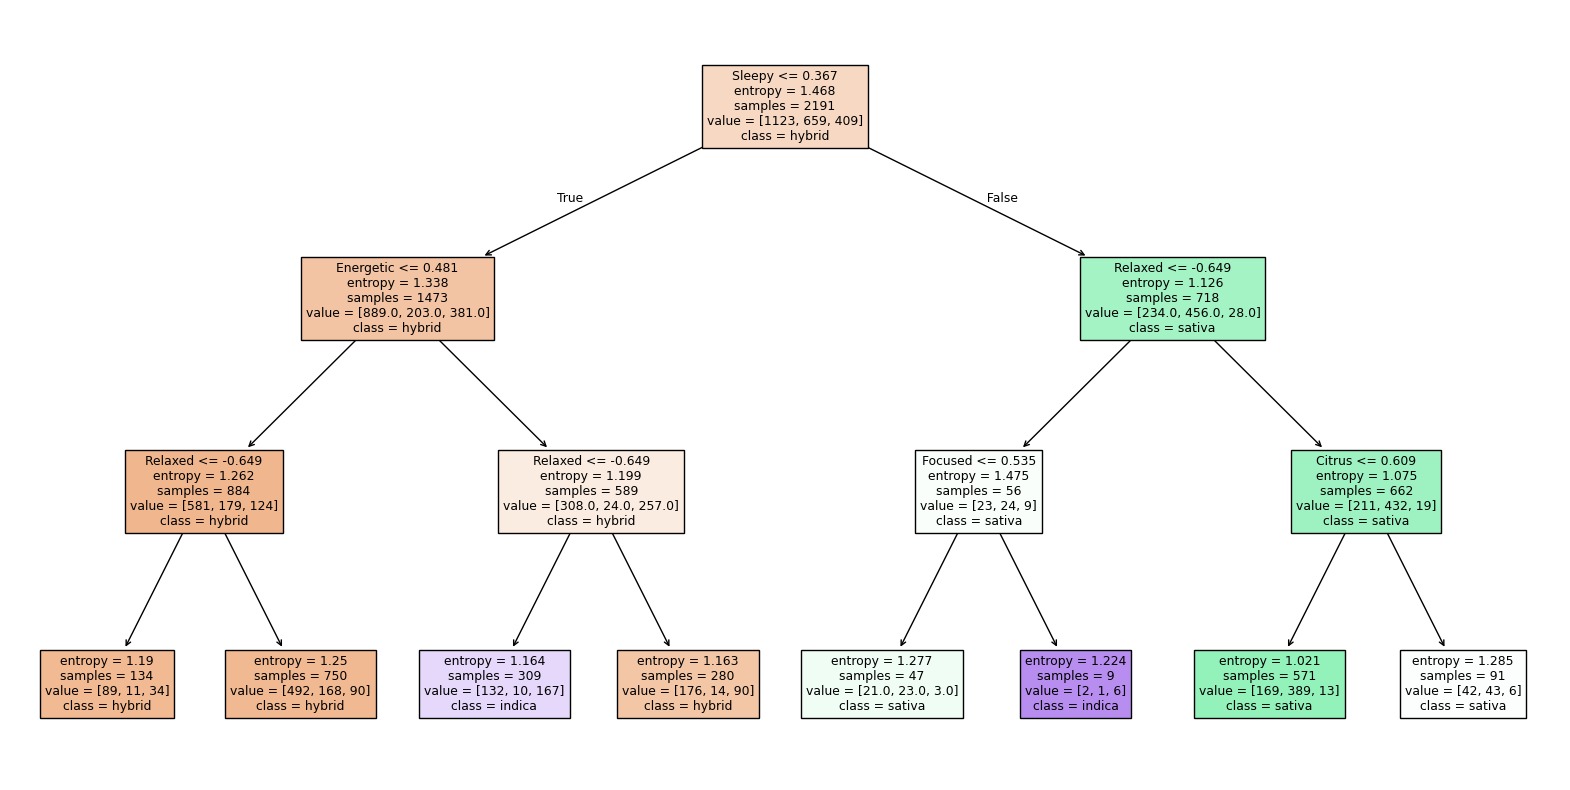

In [113]:
best_tree = grid_search.best_estimator_.named_steps['dt']
class_names = y.unique()

plt.figure(figsize=(20,10))
plot_tree(best_tree, filled=True, feature_names=X.columns, class_names=class_names)
plt.show()

It seems like there could be some bias since there are so many more hybrid strains than pure strains but it seems that sleepy is the biggest factor of whether it will be a hybrid/indica or a hybrid/sativa.

## Q2: LDA, QDA, KNN

### LDA 

I switched to an weighted f1_score since the ROC-AUC was giving me a nan and is mainly used for binary classification and we are not able to use OVR or OVO in this section. 

In [114]:
# unused solvers: "svd", "lsqr", 
param_grid = {
    "lda__solver": ["eigen"],  # Different solvers for LDA
    "lda__priors": [None],  # Uniform priors or None (learned from the data)
    "lda__n_components": [1, 2, 3],  # Different number of components (for dimensionality reduction)
    "lda__shrinkage": ["auto"],  # Only applicable if solver="lsqr"
    "lda__tol": [1e-4, 1e-3]  # Different tolerance levels
}

# Define the pipeline for LDA 
lda_pipeline = Pipeline(
    [("preprocessing", ct),
     ("lda", LinearDiscriminantAnalysis())]  # Default classifier
)

# Fit the GridSearchCV
grid_search = GridSearchCV(
    lda_pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=5),  # Ensures proper class distribution
    scoring="f1_weighted",
    n_jobs=-1
)

evaluate_grid_search(grid_search, X, y)


Best Parameters: {'lda__n_components': 1, 'lda__priors': None, 'lda__shrinkage': 'auto', 'lda__solver': 'eigen', 'lda__tol': 0.0001}
Best Cross-validated Metric: 0.6173
Classification Report:
              precision    recall  f1-score   support

      hybrid       0.66      0.66      0.66      1123
      indica       0.66      0.69      0.68       659
      sativa       0.53      0.51      0.52       409

    accuracy                           0.64      2191
   macro avg       0.62      0.62      0.62      2191
weighted avg       0.64      0.64      0.64      2191

Confusion Matrix:
[[739 211 173]
 [191 453  15]
 [182  19 208]]


c:\Users\hblin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [0.61726593 0.61726593 0.61726593 0.61726593        nan        nan]


### QDA

In [115]:
param_grid = {
    'qda__priors': [None, .5],  # Priors for class probabilities
    'qda__reg_param': [0.0, 0.1, 0.5],  # Regularization parameter (optional)
    'qda__tol': [1e-4, 1e-3]  # Tolerance for eigenvalue decomposition (optional)
}

# Define the pipeline for QDA 
qda_pipeline = Pipeline(
    [("preprocessing", ct),
     ("qda", QuadraticDiscriminantAnalysis())]  # Default classifier
)

# Fit the GridSearchCV
grid_search = GridSearchCV(
    qda_pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=5),  # Ensures proper class distribution
    scoring="f1_weighted",
    n_jobs=-1
)

evaluate_grid_search(grid_search, X, y)

c:\Users\hblin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [0.19816971 0.19816971 0.40120018 0.40120018 0.48867278 0.48867278
        nan        nan        nan        nan        nan        nan]
c:\Users\hblin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear


Best Parameters: {'qda__priors': None, 'qda__reg_param': 0.5, 'qda__tol': 0.0001}
Best Cross-validated Metric: 0.4887
Classification Report:
              precision    recall  f1-score   support

      hybrid       0.76      0.47      0.58      1123
      indica       0.62      0.77      0.69       659
      sativa       0.45      0.74      0.56       409

    accuracy                           0.61      2191
   macro avg       0.61      0.66      0.61      2191
weighted avg       0.66      0.61      0.61      2191

Confusion Matrix:
[[530 287 306]
 [ 87 509  63]
 [ 77  28 304]]


### KNN

In [119]:
param_grid = {
    "knn__n_neighbors": list(range(5, 100, 5)),  # From 5 to 100 in steps of 5
    "knn__weights": ["uniform", "distance"],  # Different weighting schemes
    "knn__p": [1, 2]  # 1 for Manhattan, 2 for Euclidean distance
}

knn_pipeline = Pipeline(
    [("preprocessing", ct),
     ("knn", KNeighborsClassifier())]  # Default classifier
)

# Fit the GridSearchCV
grid_search = GridSearchCV(
    knn_pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=5),  # Ensures proper class distribution
    scoring="f1_weighted",
    n_jobs=-1
)
grid_search.fit(X, y)

evaluate_grid_search(grid_search, X, y)

Best Parameters: {'knn__n_neighbors': 20, 'knn__p': 1, 'knn__weights': 'distance'}
Best Cross-validated Metric: 0.5696
Classification Report:
              precision    recall  f1-score   support

      hybrid       0.98      1.00      0.99      1123
      indica       0.99      0.98      0.99       659
      sativa       1.00      0.98      0.99       409

    accuracy                           0.99      2191
   macro avg       0.99      0.99      0.99      2191
weighted avg       0.99      0.99      0.99      2191

Confusion Matrix:
[[1120    2    1]
 [  12  647    0]
 [   7    2  400]]


## Q3:

Were your metrics better or worse than in Part One? Why? Which categories were most likely to get mixed up, according to the confusion matrices? Why?

The metrics were generally worse than in part 1 with the exception of KNN. With the amount of hybrids, this seemed to skew results, and ended up with them being wrongly predicted. This is most likely because as hybrids, they blend the two strains and are not as easily predicted. The KNN model predicted them very well though. This makes sense overall as with more classes, you are more likely to have more error. 

# Part 3: Multiclass from Binary

SVC and Logistic Regression

## Q1

Fit and report metrics for OvR versions of the models. That is, for each of the two model types, create three models:

Indica vs. Not Indica

Sativa vs. Not Sativa

Hybrid vs. Not Hybrid

In [120]:
cbd['indica'] = (cbd['Type'] == "indica").astype(int)
cbd['sativa'] = (cbd['Type'] == "sativa").astype(int)
cbd['hybrid'] = (cbd['Type'] == "hybrid").astype(int)

In [121]:
X_ovr = cbd.drop(["Strain", "Type", "Effects", "Flavor", "indica","sativa","hybrid"], axis = 1)

y_ovr_i = cbd['indica']

y_ovr_s = cbd['sativa']

y_ovr_h = cbd['hybrid']

### SVC

In [122]:
param_grid = {
    "svc__C": [0.1, 1, 10, 100, 1000],
    "svc__kernel": ['poly'],
    "svc__class_weight": [None, 'balanced'],
    "svc__shrinking": [True, False],
    "svc__tol": [1e-4, 1e-5, 1e-6],
    "svc__max_iter": [1000, 5000, -1]
}

svc_pipeline = Pipeline([
    ("preprocessing", ct),
    ("svc", SVC(probability=True))  # Use probability=True for probability outputs
])

# Define the parameter grid for C (regularization parameter)

grid_search = GridSearchCV(
    svc_pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=5),  # Ensures proper class distribution
    scoring="f1_weighted",
    n_jobs=-1
)

print("Indica classification: ")
evaluate_grid_search(grid_search, X_ovr, y_ovr_i)

print("Sativa classification: ")
evaluate_grid_search(grid_search, X_ovr, y_ovr_s)

print("Hybrid classification: ")
evaluate_grid_search(grid_search, X_ovr, y_ovr_h)

Indica classification: 


c:\Users\hblin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


Best Parameters: {'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__kernel': 'poly', 'svc__max_iter': 5000, 'svc__shrinking': True, 'svc__tol': 0.0001}
Best Cross-validated Metric: 0.7533
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      1532
           1       0.84      0.97      0.90       659

    accuracy                           0.93      2191
   macro avg       0.91      0.94      0.92      2191
weighted avg       0.94      0.93      0.94      2191

Confusion Matrix:
[[1410  122]
 [  23  636]]
Sativa classification: 


c:\Users\hblin\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast


Best Parameters: {'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__kernel': 'poly', 'svc__max_iter': 5000, 'svc__shrinking': True, 'svc__tol': 0.0001}
Best Cross-validated Metric: 0.8048
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1782
           1       0.73      0.78      0.75       409

    accuracy                           0.90      2191
   macro avg       0.84      0.86      0.85      2191
weighted avg       0.91      0.90      0.91      2191

Confusion Matrix:
[[1664  118]
 [  91  318]]
Hybrid classification: 
Best Parameters: {'svc__C': 10, 'svc__class_weight': None, 'svc__kernel': 'poly', 'svc__max_iter': 5000, 'svc__shrinking': True, 'svc__tol': 0.0001}
Best Cross-validated Metric: 0.5908
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1068
           1       0.89      0.92      0.90      1123

    accuracy       

c:\Users\hblin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


### Logistic

In [124]:
param_grid = {
    "lgr__C": [0.001, 0.1, 1, 10, 100],  # Regularization strength
    "lgr__penalty": ["l2"],  # L2 penalty (regularization term)
    "lgr__solver": ["lbfgs", "liblinear"],  # Different solvers
}

lgr_pipeline = Pipeline(
    [("preprocessing", ct),
     ("lgr", LogisticRegression())]  # Default classifier
)

grid_search = GridSearchCV(
    lgr_pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=5),  # Ensures proper class distribution
    scoring="f1_weighted",
    n_jobs=-1
)

print("Indica classification: ")
evaluate_grid_search(grid_search, X_ovr, y_ovr_i)

print("Sativa classification: ")
evaluate_grid_search(grid_search, X_ovr, y_ovr_s)

print("Hybrid classification: ")
evaluate_grid_search(grid_search, X_ovr, y_ovr_h)

Indica classification: 
Best Parameters: {'lgr__C': 0.1, 'lgr__penalty': 'l2', 'lgr__solver': 'liblinear'}
Best Cross-validated Metric: 0.7893
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1532
           1       0.70      0.65      0.68       659

    accuracy                           0.81      2191
   macro avg       0.78      0.77      0.77      2191
weighted avg       0.81      0.81      0.81      2191

Confusion Matrix:
[[1349  183]
 [ 230  429]]
Sativa classification: 
Best Parameters: {'lgr__C': 0.001, 'lgr__penalty': 'l2', 'lgr__solver': 'liblinear'}
Best Cross-validated Metric: 0.8128
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.89      1782
           1       0.53      0.50      0.52       409

    accuracy                           0.82      2191
   macro avg       0.71      0.70      0.70      2191
weighted avg       0.8

## Q2

Based on the OVR weighted f1 results, the best model was the Logistic Sativa Classification, and the worst was the SVC Hybrid Classification. This does make sense since previous models were having difficulty distinguishing hybrids before. It could be because there are so many more hybrids in the dataset as well. 

## Q3

Fit and report metrics for OvO versions of the models. That is, for each of the two model types, create three models:

Indica vs. Sativa

Indica vs. Hybrid

Hybrid vs. Sativa

In [125]:
X_ovo = cbd.drop(["indica","sativa","hybrid"], axis = 1)


indsat = cbd[cbd['Type'].isin(["indica", "sativa"])]
X_indsat = indsat.drop(["Strain", "Type", "Effects", "Flavor","indica","sativa","hybrid"], axis = 1)
y_indsat = indsat["Type"]

indhyb = cbd[cbd['Type'].isin(["indica", "hybrid"])]
X_indhyb = indhyb.drop(["Strain", "Type", "Effects", "Flavor", "indica","sativa","hybrid"], axis = 1)
y_indhyb = indhyb["Type"]

hybsat = cbd[cbd['Type'].isin(["hybrid", "sativa"])]
X_hybsat = hybsat.drop(["Strain", "Type", "Effects", "Flavor", "indica","sativa","hybrid"], axis = 1)
y_hybsat = hybsat["Type"]



### SVC 

In [126]:
param_grid = {
    "svc__C": [0.1, 1, 10, 100, 1000],
    "svc__kernel": ['poly'],
    "svc__class_weight": [None, 'balanced'],
    "svc__shrinking": [True, False],
    "svc__tol": [1e-4, 1e-5, 1e-6],
    "svc__max_iter": [1000, 5000, -1]
}

svc_pipeline = Pipeline([
    ("preprocessing", ct),
    ("svc", SVC(probability=True))  # Use probability=True for probability outputs
])

# Define the parameter grid for C (regularization parameter)

grid_search = GridSearchCV(
    svc_pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=5),  # Ensures proper class distribution
    scoring="f1_weighted",
    n_jobs=-1
)

print("Indica vs. Sativa: ")
evaluate_grid_search(grid_search, X_indsat, y_indsat)

print("Indica vs. Hybrid: ")
evaluate_grid_search(grid_search, X_indhyb, y_indhyb)

print("Hybrid vs. Sativa: ")
evaluate_grid_search(grid_search, X_hybsat, y_hybsat)

Indica vs. Sativa: 
Best Parameters: {'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__kernel': 'poly', 'svc__max_iter': 5000, 'svc__shrinking': True, 'svc__tol': 0.0001}
Best Cross-validated Metric: 0.8490
Classification Report:
              precision    recall  f1-score   support

      indica       0.98      0.99      0.99       659
      sativa       0.99      0.97      0.98       409

    accuracy                           0.98      1068
   macro avg       0.98      0.98      0.98      1068
weighted avg       0.98      0.98      0.98      1068

Confusion Matrix:
[[653   6]
 [ 13 396]]
Indica vs. Hybrid: 


c:\Users\hblin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


Best Parameters: {'svc__C': 10, 'svc__class_weight': None, 'svc__kernel': 'poly', 'svc__max_iter': 1000, 'svc__shrinking': True, 'svc__tol': 0.0001}
Best Cross-validated Metric: 0.7119
Classification Report:
              precision    recall  f1-score   support

      hybrid       0.95      0.94      0.95      1123
      indica       0.91      0.91      0.91       659

    accuracy                           0.93      1782
   macro avg       0.93      0.93      0.93      1782
weighted avg       0.93      0.93      0.93      1782

Confusion Matrix:
[[1061   62]
 [  61  598]]
Hybrid vs. Sativa: 
Best Parameters: {'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__kernel': 'poly', 'svc__max_iter': 1000, 'svc__shrinking': True, 'svc__tol': 0.0001}
Best Cross-validated Metric: 0.7261
Classification Report:
              precision    recall  f1-score   support

      hybrid       0.91      0.24      0.38      1123
      sativa       0.31      0.94      0.47       409

    accuracy           

c:\Users\hblin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


### Logistic

In [ ]:
param_grid = {
    "lgr__C": [0.001, 0.1, 1, 10, 100],  # Regularization strength
    "lgr__penalty": ["l2"],  # L2 penalty (regularization term)
    "lgr__solver": ["lbfgs", "liblinear"],  # Different solvers
}

lgr_pipeline = Pipeline(
    [("preprocessing", ct),
     ("lgr", LogisticRegression())]  # Default classifier
)

grid_search = GridSearchCV(
    lgr_pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=5),  # Ensures proper class distribution
    scoring="f1_weighted",
    n_jobs=-1
)

print("Indica vs. Sativa: ")
evaluate_grid_search(grid_search, X_indsat, y_indsat)

print("Indica vs. Hybrid: ")
evaluate_grid_search(grid_search, X_indhyb, y_indhyb)

print("Hybrid vs. Sativa: ")
evaluate_grid_search(grid_search, X_hybsat, y_hybsat)

Indica vs. Sativa: 
Best Parameters: {'lgr__C': 0.001, 'lgr__penalty': 'l2', 'lgr__solver': 'liblinear'}
Best Cross-validated Metric: 0.9385
Classification Report:
              precision    recall  f1-score   support

      indica       0.92      0.89      0.90       659
      sativa       0.83      0.87      0.85       409

    accuracy                           0.88      1068
   macro avg       0.87      0.88      0.88      1068
weighted avg       0.88      0.88      0.88      1068

Confusion Matrix:
[[585  74]
 [ 53 356]]
Indica vs. Hybrid: 
Best Parameters: {'lgr__C': 0.001, 'lgr__penalty': 'l2', 'lgr__solver': 'lbfgs'}
Best Cross-validated Metric: 0.8040
Classification Report:
              precision    recall  f1-score   support

      hybrid       0.71      0.93      0.81      1123
      indica       0.75      0.36      0.49       659

    accuracy                           0.72      1782
   macro avg       0.73      0.65      0.65      1782
weighted avg       0.73      0.72   

## Q4


Which of the six models did the best job distinguishing at differentiating the two groups? Which did the worst? Does this make intuitive sense?

The best model was the Logistic Indica vs Sativa model in terms of the ovo weighted f1. The worst model was the hybrid vs indica SVC. Hybrids seem to still be difficult to identify even with a weighted f1. The hybrids may also hold a lot of similar characteristics to one strain or the other. 

## Q5


Suppose you had simply input the full data, with three classes, into the LogisticRegression function. Would this have automatically taken an “OvO” approach or an “OvR” approach?

What about for SVC?

They both take on the OVR method as a default. 

LogisticRegression:

Logistic Regression (aka logit, MaxEnt) classifier.

In the multiclass case, the training algorithm uses the one-vs-rest (OvR) scheme if the ‘multi_class’ option is set to ‘ovr’, and uses the cross-entropy loss if the ‘multi_class’ option is set to ‘multinomial’. (Currently the ‘multinomial’ option is supported only by the ‘lbfgs’, ‘sag’, ‘saga’ and ‘newton-cg’ solvers.)


SVC:

decision_function_shape{‘ovo’, ‘ovr’}, default=’ovr’
Whether to return a one-vs-rest (‘ovr’) decision function of shape (n_samples, n_classes) as all other classifiers, or the original one-vs-one (‘ovo’) decision function of libsvm which has shape (n_samples, n_classes * (n_classes - 1) / 2). However, note that internally, one-vs-one (‘ovo’) is always used as a multi-class strategy to train models; an ovr matrix is only constructed from the ovo matrix. The parameter is ignored for binary classification.